In [8]:
pip install keras-cv --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.experimental import numpy as tfnp


class TextEncoder(keras.Model):
    def __init__(
        self, max_length, vocab_size=49408, name=None, download_weights=True
    ):
        tokens = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="tokens"
        )
        positions = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="positions"
        )
        x = CLIPEmbedding(vocab_size, 768, max_length)([tokens, positions])
        for _ in range(12):
            x = CLIPEncoderLayer(768, 12, activation=quick_gelu)(x)
        embedded = keras.layers.LayerNormalization(epsilon=1e-5)(x)
        super().__init__([tokens, positions], embedded, name=name)

        if download_weights:
            text_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_encoder.h5",  # noqa: E501
                file_hash="4789e63e07c0e54d6a34a29b45ce81ece27060c499a709d556c7755b42bb0dc4",  # noqa: E501
            )
            self.load_weights(text_encoder_weights_fpath)


class TextEncoderV2(keras.Model):
    def __init__(
        self, max_length, vocab_size=49408, name=None, download_weights=True
    ):
        tokens = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="tokens"
        )
        positions = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="positions"
        )
        x = CLIPEmbedding(vocab_size, 1024, max_length)([tokens, positions])
        for _ in range(23):
            x = CLIPEncoderLayer(1024, 16, activation=tf.nn.gelu)(x)
        embedded = keras.layers.LayerNormalization(epsilon=1e-5)(x)
        super().__init__([tokens, positions], embedded, name=name)

        if download_weights:
            text_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/text_encoder_v2_1.h5",  # noqa: E501
                file_hash="985002e68704e1c5c3549de332218e99c5b9b745db7171d5f31fcd9a6089f25b",  # noqa: E501
            )
            self.load_weights(text_encoder_weights_fpath)


def quick_gelu(x):
    return x * tf.sigmoid(x * 1.702)


class CLIPEmbedding(keras.layers.Layer):
    def __init__(
        self, input_dim=49408, output_dim=768, max_length=77, **kwargs
    ):
        super().__init__(**kwargs)
        self.token_embedding = keras.layers.Embedding(input_dim, output_dim)
        self.position_embedding = keras.layers.Embedding(max_length, output_dim)

    def call(self, inputs):
        tokens, positions = inputs
        tokens = self.token_embedding(tokens)
        positions = self.position_embedding(positions)
        return tokens + positions


class CLIPEncoderLayer(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.clip_attn = CLIPAttention(embed_dim, num_heads, causal=True)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.fc1 = keras.layers.Dense(embed_dim * 4)
        self.fc2 = keras.layers.Dense(embed_dim)
        self.activation = activation

    def call(self, inputs):
        residual = inputs
        x = self.layer_norm1(inputs)
        x = self.clip_attn(x)
        x = residual + x
        residual = x
        x = self.layer_norm2(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x + residual


class CLIPAttention(keras.layers.Layer):
    def __init__(self, embed_dim=768, num_heads=12, causal=True, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.causal = causal
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.q_proj = keras.layers.Dense(self.embed_dim)
        self.k_proj = keras.layers.Dense(self.embed_dim)
        self.v_proj = keras.layers.Dense(self.embed_dim)
        self.out_proj = keras.layers.Dense(self.embed_dim)

    def reshape_states(self, x, sequence_length, batch_size):
        x = tf.reshape(
            x, (batch_size, sequence_length, self.num_heads, self.head_dim)
        )
        return tf.transpose(
            x, (0, 2, 1, 3)
        )  # bs, heads, sequence_length, head_dim

    def call(self, inputs, attention_mask=None):
        if attention_mask is None and self.causal:
            length = tf.shape(inputs)[1]
            attention_mask = tfnp.triu(
                tf.ones((1, 1, length, length), dtype=self.compute_dtype)
                * -tfnp.inf,
                k=1,
            )

        _, tgt_len, embed_dim = inputs.shape
        query_states = self.q_proj(inputs) * self.scale
        key_states = self.reshape_states(self.k_proj(inputs), tgt_len, -1)
        value_states = self.reshape_states(self.v_proj(inputs), tgt_len, -1)

        proj_shape = (-1, tgt_len, self.head_dim)
        query_states = self.reshape_states(query_states, tgt_len, -1)
        query_states = tf.reshape(query_states, proj_shape)
        key_states = tf.reshape(key_states, proj_shape)

        src_len = tgt_len
        value_states = tf.reshape(value_states, proj_shape)
        attn_weights = query_states @ tf.transpose(key_states, (0, 2, 1))

        attn_weights = tf.reshape(
            attn_weights, (-1, self.num_heads, tgt_len, src_len)
        )
        attn_weights = attn_weights + attention_mask
        attn_weights = tf.reshape(attn_weights, (-1, tgt_len, src_len))

        attn_weights = tf.nn.softmax(attn_weights)
        attn_output = attn_weights @ value_states

        attn_output = tf.reshape(
            attn_output, (-1, self.num_heads, tgt_len, self.head_dim)
        )
        attn_output = tf.transpose(attn_output, (0, 2, 1, 3))
        attn_output = tf.reshape(attn_output, (-1, tgt_len, embed_dim))
        return self.out_proj(attn_output)

In [ ]:
from tensorflow import keras


class PaddedConv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding=0, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.padding2d = keras.layers.ZeroPadding2D(padding)
        self.conv2d = keras.layers.Conv2D(filters, kernel_size, strides=strides)

    def call(self, inputs):
        x = self.padding2d(inputs)
        return self.conv2d(x)

In [ ]:
import tensorflow as tf
from tensorflow import keras




class DiffusionModel(keras.Model):
    def __init__(
        self,
        img_height,
        img_width,
        max_text_length,
        name=None,
        download_weights=True,
    ):
        context = keras.layers.Input((max_text_length, 768))
        t_embed_input = keras.layers.Input((320,))
        latent = keras.layers.Input((img_height // 8, img_width // 8, 4))

        t_emb = keras.layers.Dense(1280)(t_embed_input)
        t_emb = keras.layers.Activation("swish")(t_emb)
        t_emb = keras.layers.Dense(1280)(t_emb)

        # Downsampling flow

        outputs = []
        x = PaddedConv2D(320, kernel_size=3, padding=1)(latent)
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(320, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(640, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(1280, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            outputs.append(x)

        # Middle flow

        x = ResBlock(1280)([x, t_emb])
        x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = ResBlock(1280)([x, t_emb])

        # Upsampling flow

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
        x = Upsample(640)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])

        # Exit flow

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        output = PaddedConv2D(4, kernel_size=3, padding=1)(x)

        super().__init__([latent, t_embed_input, context], output, name=name)

        if download_weights:
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",  # noqa: E501
                file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",  # noqa: E501
            )
            self.load_weights(diffusion_model_weights_fpath)


class DiffusionModelV2(keras.Model):
    def __init__(
        self,
        img_height,
        img_width,
        max_text_length,
        name=None,
        download_weights=True,
    ):
        context = keras.layers.Input((max_text_length, 1024))
        t_embed_input = keras.layers.Input((320,))
        latent = keras.layers.Input((img_height // 8, img_width // 8, 4))

        t_emb = keras.layers.Dense(1280)(t_embed_input)
        t_emb = keras.layers.Activation("swish")(t_emb)
        t_emb = keras.layers.Dense(1280)(t_emb)

        # Downsampling flow

        outputs = []
        x = PaddedConv2D(320, kernel_size=3, padding=1)(latent)
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(5, 64, fully_connected=True)([x, context])
            outputs.append(x)
        x = PaddedConv2D(320, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(10, 64, fully_connected=True)([x, context])
            outputs.append(x)
        x = PaddedConv2D(640, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(20, 64, fully_connected=True)([x, context])
            outputs.append(x)
        x = PaddedConv2D(1280, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            outputs.append(x)

        # Middle flow

        x = ResBlock(1280)([x, t_emb])
        x = SpatialTransformer(20, 64, fully_connected=True)([x, context])
        x = ResBlock(1280)([x, t_emb])

        # Upsampling flow

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(20, 64, fully_connected=True)([x, context])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(10, 64, fully_connected=True)([x, context])
        x = Upsample(640)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(5, 64, fully_connected=True)([x, context])

        # Exit flow

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        output = PaddedConv2D(4, kernel_size=3, padding=1)(x)

        super().__init__([latent, t_embed_input, context], output, name=name)

        if download_weights:
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/diffusion_model_v2_1.h5",  # noqa: E501
                file_hash="c31730e91111f98fe0e2dbde4475d381b5287ebb9672b1821796146a25c5132d",  # noqa: E501
            )
            self.load_weights(diffusion_model_weights_fpath)


class ResBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.entry_flow = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.layers.Activation("swish"),
            PaddedConv2D(output_dim, 3, padding=1),
        ]
        self.embedding_flow = [
            keras.layers.Activation("swish"),
            keras.layers.Dense(output_dim),
        ]
        self.exit_flow = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.layers.Activation("swish"),
            PaddedConv2D(output_dim, 3, padding=1),
        ]

    def build(self, input_shape):
        if input_shape[0][-1] != self.output_dim:
            self.residual_projection = PaddedConv2D(self.output_dim, 1)
        else:
            self.residual_projection = lambda x: x

    def call(self, inputs):
        inputs, embeddings = inputs
        x = inputs
        for layer in self.entry_flow:
            x = layer(x)
        for layer in self.embedding_flow:
            embeddings = layer(embeddings)
        x = x + embeddings[:, None, None]
        for layer in self.exit_flow:
            x = layer(x)
        return x + self.residual_projection(inputs)


class SpatialTransformer(keras.layers.Layer):
    def __init__(self, num_heads, head_size, fully_connected=False, **kwargs):
        super().__init__(**kwargs)
        self.norm = keras.layers.GroupNormalization(epsilon=1e-5)
        channels = num_heads * head_size
        if fully_connected:
            self.proj1 = keras.layers.Dense(num_heads * head_size)
        else:
            self.proj1 = PaddedConv2D(num_heads * head_size, 1)
        self.transformer_block = BasicTransformerBlock(
            channels, num_heads, head_size
        )
        if fully_connected:
            self.proj2 = keras.layers.Dense(channels)
        else:
            self.proj2 = PaddedConv2D(channels, 1)

    def call(self, inputs):
        inputs, context = inputs
        _, h, w, c = inputs.shape
        x = self.norm(inputs)
        x = self.proj1(x)
        x = tf.reshape(x, (-1, h * w, c))
        x = self.transformer_block([x, context])
        x = tf.reshape(x, (-1, h, w, c))
        return self.proj2(x) + inputs


class BasicTransformerBlock(keras.layers.Layer):
    def __init__(self, dim, num_heads, head_size, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn1 = CrossAttention(num_heads, head_size)
        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn2 = CrossAttention(num_heads, head_size)
        self.norm3 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.geglu = GEGLU(dim * 4)
        self.dense = keras.layers.Dense(dim)

    def call(self, inputs):
        inputs, context = inputs
        x = self.attn1([self.norm1(inputs), None]) + inputs
        x = self.attn2([self.norm2(x), context]) + x
        return self.dense(self.geglu(self.norm3(x))) + x


class CrossAttention(keras.layers.Layer):
    def __init__(self, num_heads, head_size, **kwargs):
        super().__init__(**kwargs)
        self.to_q = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.to_k = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.to_v = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.scale = head_size**-0.5
        self.num_heads = num_heads
        self.head_size = head_size
        self.out_proj = keras.layers.Dense(num_heads * head_size)

    def call(self, inputs):
        inputs, context = inputs
        context = inputs if context is None else context
        q, k, v = self.to_q(inputs), self.to_k(context), self.to_v(context)
        q = tf.reshape(q, (-1, inputs.shape[1], self.num_heads, self.head_size))
        k = tf.reshape(
            k, (-1, context.shape[1], self.num_heads, self.head_size)
        )
        v = tf.reshape(
            v, (-1, context.shape[1], self.num_heads, self.head_size)
        )

        q = tf.transpose(q, (0, 2, 1, 3))  # (bs, num_heads, time, head_size)
        k = tf.transpose(k, (0, 2, 3, 1))  # (bs, num_heads, head_size, time)
        v = tf.transpose(v, (0, 2, 1, 3))  # (bs, num_heads, time, head_size)

        score = td_dot(q, k) * self.scale
        weights = keras.activations.softmax(
            score
        )  # (bs, num_heads, time, time)
        attn = td_dot(weights, v)
        attn = tf.transpose(
            attn, (0, 2, 1, 3)
        )  # (bs, time, num_heads, head_size)
        out = tf.reshape(
            attn, (-1, inputs.shape[1], self.num_heads * self.head_size)
        )
        return self.out_proj(out)


class Upsample(keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.ups = keras.layers.UpSampling2D(2)
        self.conv = PaddedConv2D(channels, 3, padding=1)

    def call(self, inputs):
        return self.conv(self.ups(inputs))


class GEGLU(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.dense = keras.layers.Dense(output_dim * 2)

    def call(self, inputs):
        x = self.dense(inputs)
        x, gate = x[..., : self.output_dim], x[..., self.output_dim :]
        tanh_res = keras.activations.tanh(
            gate * 0.7978845608 * (1 + 0.044715 * (gate**2))
        )
        return x * 0.5 * gate * (1 + tanh_res)


def td_dot(a, b):
    aa = tf.reshape(a, (-1, a.shape[2], a.shape[3]))
    bb = tf.reshape(b, (-1, b.shape[2], b.shape[3]))
    cc = keras.backend.batch_dot(aa, bb)
    return tf.reshape(cc, (-1, a.shape[1], cc.shape[1], cc.shape[2]))

In [ ]:
import tensorflow as tf
from tensorflow import keras




class AttentionBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm = keras.layers.GroupNormalization(epsilon=1e-5)
        self.q = PaddedConv2D(output_dim, 1)
        self.k = PaddedConv2D(output_dim, 1)
        self.v = PaddedConv2D(output_dim, 1)
        self.proj_out = PaddedConv2D(output_dim, 1)

    def call(self, inputs):
        x = self.norm(inputs)
        q, k, v = self.q(x), self.k(x), self.v(x)

        # Compute attention
        shape = tf.shape(q)
        h, w, c = shape[1], shape[2], shape[3]
        q = tf.reshape(q, (-1, h * w, c))  # b, hw, c
        k = tf.transpose(k, (0, 3, 1, 2))
        k = tf.reshape(k, (-1, c, h * w))  # b, c, hw
        y = q @ k
        y = y * 1 / tf.sqrt(tf.cast(c, self.compute_dtype))
        y = keras.activations.softmax(y)

        # Attend to values
        v = tf.transpose(v, (0, 3, 1, 2))
        v = tf.reshape(v, (-1, c, h * w))
        y = tf.transpose(y, (0, 2, 1))
        x = v @ y
        x = tf.transpose(x, (0, 2, 1))
        x = tf.reshape(x, (-1, h, w, c))
        return self.proj_out(x) + inputs

In [ ]:
from tensorflow import keras




class ResnetBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm1 = keras.layers.GroupNormalization(epsilon=1e-5)
        self.conv1 = PaddedConv2D(output_dim, 3, padding=1)
        self.norm2 = keras.layers.GroupNormalization(epsilon=1e-5)
        self.conv2 = PaddedConv2D(output_dim, 3, padding=1)

    def build(self, input_shape):
        if input_shape[-1] != self.output_dim:
            self.residual_projection = PaddedConv2D(self.output_dim, 1)
        else:
            self.residual_projection = lambda x: x

    def call(self, inputs):
        x = self.conv1(keras.activations.swish(self.norm1(inputs)))
        x = self.conv2(keras.activations.swish(self.norm2(x)))
        return x + self.residual_projection(inputs)

In [ ]:
from tensorflow import keras





class Decoder(keras.Sequential):
    def __init__(self, img_height, img_width, name=None, download_weights=True):
        super().__init__(
            [
                keras.layers.Input((img_height // 8, img_width // 8, 4)),
                keras.layers.Rescaling(1.0 / 0.18215),
                PaddedConv2D(4, 1),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512),
                AttentionBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(256),
                ResnetBlock(256),
                ResnetBlock(256),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(256, 3, padding=1),
                ResnetBlock(128),
                ResnetBlock(128),
                ResnetBlock(128),
                keras.layers.GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(3, 3, padding=1),
            ],
            name=name,
        )

        if download_weights:
            decoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_decoder.h5",  # noqa: E501
                file_hash="ad350a65cc8bc4a80c8103367e039a3329b4231c2469a1093869a345f55b1962",  # noqa: E501
            )
            self.load_weights(decoder_weights_fpath)

In [ ]:

import gzip
import html
from functools import lru_cache

import regex as re
from tensorflow import keras


@lru_cache()
def bytes_to_unicode():
    """Return a list of utf-8 bytes and a corresponding list of unicode strings.

    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you
    want to avoid UNKs. When you're at something like a 10B token dataset you
    end up needing around 5K for decent coverage. This is a significant
    percentage of your normal, say, 32K bpe vocab. To avoid that, we want
    lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1))
        + list(range(ord("¡"), ord("¬") + 1))
        + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.

    A word is represented as tuple of symbols(symbols being variable-length
    strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text


class SimpleTokenizer:
    def __init__(self, bpe_path=None):
        bpe_path = bpe_path or keras.utils.get_file(
            "bpe_simple_vocab_16e6.txt.gz",
            "https://github.com/openai/CLIP/blob/main/clip/bpe_simple_vocab_16e6.txt.gz?raw=true",  # noqa: E501
            file_hash="924691ac288e54409236115652ad4aa250f48203de50a9e4722a6ecd48d6804a",  # noqa: E501
        )
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split("\n")
        merges = merges[1 : 49152 - 256 - 2 + 1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v + "</w>" for v in vocab]
        for merge in merges:
            vocab.append("".join(merge))
        vocab.extend(["<|startoftext|>", "<|endoftext|>"])
        self.vocab = vocab
        self.encoder = self._create_encoder(self.vocab)
        self.decoder = self._create_decoder(self.encoder)
        self.bpe_ranks = dict(zip(merges, range(len(merges))))

        self.special_tokens = {
            "<|startoftext|>": "<|startoftext|>",
            "<|endoftext|>": "<|endoftext|>",
        }
        self.cache = {
            "<|startoftext|>": "<|startoftext|>",
            "<|endoftext|>": "<|endoftext|>",
        }
        self.pat = self._create_pat()

    def _create_encoder(self, vocab):
        return dict(zip(vocab, range(len(vocab))))

    def _create_decoder(self, encoder):
        return {v: k for k, v in encoder.items()}

    def _create_pat(self):
        return re.compile(
            "|".join([re.escape(key) for key in self.special_tokens.keys()])
            + r"""|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""",
            re.IGNORECASE,
        )

    @property
    def end_of_text(self):
        return self.encoder["<|endoftext|>"]

    @property
    def start_of_text(self):
        return self.encoder["<|startoftext|>"]

    def add_tokens(self, tokens):
        if isinstance(tokens, str):
            tokens = [tokens]
        tokens_added = 0
        for token in tokens:
            if token in self.vocab:
                continue
            tokens_added += 1
            self.vocab.append(token)
            self.special_tokens[token] = token
            self.cache[token] = token
        self.encoder = self._create_encoder(self.vocab)
        self.decoder = self._create_decoder(self.encoder)
        self.pat = self._create_pat()
        return tokens_added

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + (token[-1] + "</w>",)
        pairs = get_pairs(word)

        if not pairs:
            return token + "</w>"

        while True:
            bigram = min(
                pairs, key=lambda pair: self.bpe_ranks.get(pair, float("inf"))
            )
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if (
                    word[i] == first
                    and i < len(word) - 1
                    and word[i + 1] == second
                ):
                    new_word.append(first + second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = " ".join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = "".join(self.byte_encoder[b] for b in token.encode("utf-8"))
            bpe_tokens.extend(
                self.encoder[bpe_token]
                for bpe_token in self.bpe(token).split(" ")
            )
        return [self.start_of_text] + bpe_tokens + [self.end_of_text]

    def decode(self, tokens):
        text = "".join([self.decoder[token] for token in tokens])
        text = (
            bytearray([self.byte_decoder[c] for c in text])
            .decode("utf-8", errors="replace")
            .replace("</w>", " ")
        )
        return text

In [ ]:
# Copyright 2022 The KerasCV Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Keras implementation of StableDiffusion.

Credits:

- Original implementation:
  https://github.com/CompVis/stable-diffusion
- Initial TF/Keras port:
  https://github.com/divamgupta/stable-diffusion-tensorflow

The current implementation is a rewrite of the initial TF/Keras port by
Divam Gupta.
"""

import math

import numpy as np
import tensorflow as tf
from tensorflow import keras






MAX_PROMPT_LENGTH = 77


class StableDiffusionBase:
    """Base class for stable diffusion and stable diffusion v2 model."""

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=False,
    ):
        # UNet requires multiples of 2**7 = 128
        img_height = round(img_height / 128) * 128
        img_width = round(img_width / 128) * 128
        self.img_height = img_height
        self.img_width = img_width

        # lazy initialize the component models and the tokenizer
        self._image_encoder = None
        self._text_encoder = None
        self._diffusion_model = None
        self._decoder = None
        self._tokenizer = None

        self.jit_compile = jit_compile

    def text_to_image(
        self,
        prompt,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        seed=None,
    ):
        encoded_text = self.encode_text(prompt)

        return self.generate_image(
            encoded_text,
            negative_prompt=negative_prompt,
            batch_size=batch_size,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
            seed=seed,
        )

    def encode_text(self, prompt):
        """Encodes a prompt into a latent text encoding.

        The encoding produced by this method should be used as the
        `encoded_text` parameter of `StableDiffusion.generate_image`. Encoding
        text separately from generating an image can be used to arbitrarily
        modify the text encoding priot to image generation, e.g. for walking
        between two prompts.

        Args:
            prompt: a string to encode, must be 77 tokens or shorter.

        Example:

        ```python
        from keras_cv.models import StableDiffusion

        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        encoded_text  = model.encode_text("Tacos at dawn")
        img = model.generate_image(encoded_text)
        ```
        """
        # Tokenize prompt (i.e. starting context)
        inputs = self.tokenizer.encode(prompt)
        if len(inputs) > MAX_PROMPT_LENGTH:
            raise ValueError(
                f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
            )
        phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
        phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)

        context = self.text_encoder.predict_on_batch(
            [phrase, self._get_pos_ids()]
        )

        return context

    def generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        """Generates an image based on encoded text.

        The encoding passed to this method should be derived from
        `StableDiffusion.encode_text`.

        Args:
            encoded_text: Tensor of shape (`batch_size`, 77, 768), or a Tensor
                of shape (77, 768). When the batch axis is omitted, the same
                encoded text will be used to produce every generated image.
            batch_size: int, number of images to generate, defaults to 1.
            negative_prompt: a string containing information to negatively guide
                the image generation (e.g. by removing or altering certain
                aspects of the generated image), defaults to None.
            num_steps: int, number of diffusion steps (controls image quality),
                defaults to 50.
            unconditional_guidance_scale: float, controlling how closely the
                image should adhere to the prompt. Larger values result in more
                closely adhering to the prompt, but will make the image noisier.
                Defaults to 7.5.
            diffusion_noise: Tensor of shape (`batch_size`, img_height // 8,
                img_width // 8, 4), or a Tensor of shape (img_height // 8,
                img_width // 8, 4). Optional custom noise to seed the diffusion
                process. When the batch axis is omitted, the same noise will be
                used to seed diffusion for every generated image.
            seed: integer which is used to seed the random generation of
                diffusion noise, only to be specified if `diffusion_noise` is
                None.

        Example:

        ```python
        from keras_cv.models import StableDiffusion

        batch_size = 8
        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        e_tacos = model.encode_text("Tacos at dawn")
        e_watermelons = model.encode_text("Watermelons at dusk")

        e_interpolated = tf.linspace(e_tacos, e_watermelons, batch_size)
        images = model.generate_image(e_interpolated, batch_size=batch_size)
        ```
        """
        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = tf.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )

        if diffusion_noise is not None:
            diffusion_noise = tf.squeeze(diffusion_noise)
            if diffusion_noise.shape.rank == 3:
                diffusion_noise = tf.repeat(
                    tf.expand_dims(diffusion_noise, axis=0), batch_size, axis=0
                )
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        # Iterative reverse diffusion stage
        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)
            unconditional_latent = self.diffusion_model.predict_on_batch(
                [latent, t_emb, unconditional_context]
            )
            latent = self.diffusion_model.predict_on_batch(
                [latent, t_emb, context]
            )
            latent = unconditional_latent + unconditional_guidance_scale * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(
                a_t
            )
            latent = (
                latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
            )
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self.decoder.predict_on_batch(latent)
        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS], dtype=tf.int32
        )
        unconditional_context = self.text_encoder.predict_on_batch(
            [unconditional_tokens, self._get_pos_ids()]
        )

        return unconditional_context

    def _expand_tensor(self, text_embedding, batch_size):
        """Extends a tensor by repeating it to fit the shape of the given batch
        size."""
        text_embedding = tf.squeeze(text_embedding)
        if text_embedding.shape.rank == 2:
            text_embedding = tf.repeat(
                tf.expand_dims(text_embedding, axis=0), batch_size, axis=0
            )
        return text_embedding

    @property
    def image_encoder(self):
        """image_encoder returns the VAE Encoder with pretrained weights.

        Usage:
        ```python
        sd = keras_cv.models.StableDiffusion()
        my_image = np.ones((512, 512, 3))
        latent_representation = sd.image_encoder.predict(my_image)
        ```
        """
        if self._image_encoder is None:
            self._image_encoder = ImageEncoder()
            if self.jit_compile:
                self._image_encoder.compile(jit_compile=True)
        return self._image_encoder

    @property
    def text_encoder(self):
        pass

    @property
    def diffusion_model(self):
        pass

    @property
    def decoder(self):
        """decoder returns the diffusion image decoder model with pretrained
        weights. Can be overriden for tasks where the decoder needs to be
        modified.
        """
        if self._decoder is None:
            self._decoder = Decoder(self.img_height, self.img_width)
            if self.jit_compile:
                self._decoder.compile(jit_compile=True)
        return self._decoder

    @property
    def tokenizer(self):
        """tokenizer returns the tokenizer used for text inputs.
        Can be overriden for tasks like textual inversion where the tokenizer
        needs to be modified.
        """
        if self._tokenizer is None:
            self._tokenizer = SimpleTokenizer()
        return self._tokenizer

    def _get_timestep_embedding(
        self, timestep, batch_size, dim=320, max_period=10000
    ):
        half = dim // 2
        freqs = tf.math.exp(
            -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_initial_diffusion_noise(self, batch_size, seed):
        if seed is not None:
            return tf.random.stateless_normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4),
                seed=[seed, seed],
            )
        else:
            return tf.random.normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4)
            )

    @staticmethod
    def _get_pos_ids():
        return tf.convert_to_tensor(
            [list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32
        )


class StableDiffusion(StableDiffusionBase):
    """Keras implementation of Stable Diffusion.

    Note that the StableDiffusion API, as well as the APIs of the sub-components
    of StableDiffusion (e.g. ImageEncoder, DiffusionModel) should be considered
    unstable at this point. We do not guarantee backwards compatability for
    future changes to these APIs.

    Stable Diffusion is a powerful image generation model that can be used,
    among other things, to generate pictures according to a short text
    description (called a "prompt").

    Arguments:
        img_height: int, height of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        img_width: int, width of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        jit_compile: bool, whether to compile the underlying models to XLA.
            This can lead to a significant speedup on some systems. Defaults to
            False.

    Example:

    ```python
    from keras_cv.models import StableDiffusion
    from PIL import Image

    model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
    img = model.text_to_image(
        prompt="A beautiful horse running through a field",
        batch_size=1,  # How many images to generate at once
        num_steps=25,  # Number of iterations (controls image quality)
        seed=123,  # Set this to always get the same image from the same prompt
    )
    Image.fromarray(img[0]).save("horse.png")
    print("saved at horse.png")
    ```

    References:
    - [About Stable Diffusion](https://stability.ai/blog/stable-diffusion-announcement)
    - [Original implementation](https://github.com/CompVis/stable-diffusion)
    """  # noqa: E501

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=False,
    ):
        super().__init__(img_height, img_width, jit_compile)
        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL-M license at "
            "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE"  # noqa: E501
        )

    @property
    def text_encoder(self):
        """text_encoder returns the text encoder with pretrained weights.
        Can be overriden for tasks like textual inversion where the text encoder
        needs to be modified.
        """
        if self._text_encoder is None:
            self._text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
            if self.jit_compile:
                self._text_encoder.compile(jit_compile=True)
        return self._text_encoder

    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be
        modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModel(
                self.img_height, self.img_width, MAX_PROMPT_LENGTH
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model


class StableDiffusionV2(StableDiffusionBase):
    """Keras implementation of Stable Diffusion v2.

    Note that the StableDiffusion API, as well as the APIs of the sub-components
    of StableDiffusionV2 (e.g. ImageEncoder, DiffusionModelV2) should be
    considered unstable at this point. We do not guarantee backwards
    compatability for future changes to these APIs.

    Stable Diffusion is a powerful image generation model that can be used,
    among other things, to generate pictures according to a short text
    description (called a "prompt").

    Arguments:
        img_height: int, height of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        img_width: int, width of the images to generate, in pixel. Note that
            only multiples of 128 are supported; the value provided will be
            rounded to the nearest valid value. Defaults to 512.
        jit_compile: bool, whether to compile the underlying models to XLA.
            This can lead to a significant speedup on some systems. Defaults to
            False.
    Example:

    ```python
    from keras_cv.models import StableDiffusionV2
    from PIL import Image

    model = StableDiffusionV2(img_height=512, img_width=512, jit_compile=True)
    img = model.text_to_image(
        prompt="A beautiful horse running through a field",
        batch_size=1,  # How many images to generate at once
        num_steps=25,  # Number of iterations (controls image quality)
        seed=123,  # Set this to always get the same image from the same prompt
    )
    Image.fromarray(img[0]).save("horse.png")
    print("saved at horse.png")
    ```

    References:

    - [About Stable Diffusion](https://stability.ai/blog/stable-diffusion-announcement)
    - [Original implementation](https://github.com/Stability-AI/stablediffusion)
    """  # noqa: E501

    def __init__(
        self,
        img_height=512,
        img_width=512,
        jit_compile=False,
    ):
        super().__init__(img_height, img_width, jit_compile)
        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL++-M license at "
            "https://github.com/Stability-AI/stablediffusion/main/LICENSE-MODEL"
        )

    @property
    def text_encoder(self):
        """text_encoder returns the text encoder with pretrained weights.
        Can be overriden for tasks like textual inversion where the text encoder
        needs to be modified.
        """
        if self._text_encoder is None:
            self._text_encoder = TextEncoderV2(MAX_PROMPT_LENGTH)
            if self.jit_compile:
                self._text_encoder.compile(jit_compile=True)
        return self._text_encoder

    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be
        modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModelV2(
                self.img_height, self.img_width, MAX_PROMPT_LENGTH
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model

In [ ]:
pip install pycocotools

In [ ]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

Using TensorFlow backend


In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


50/50 [==============================] - 86s 2s/step


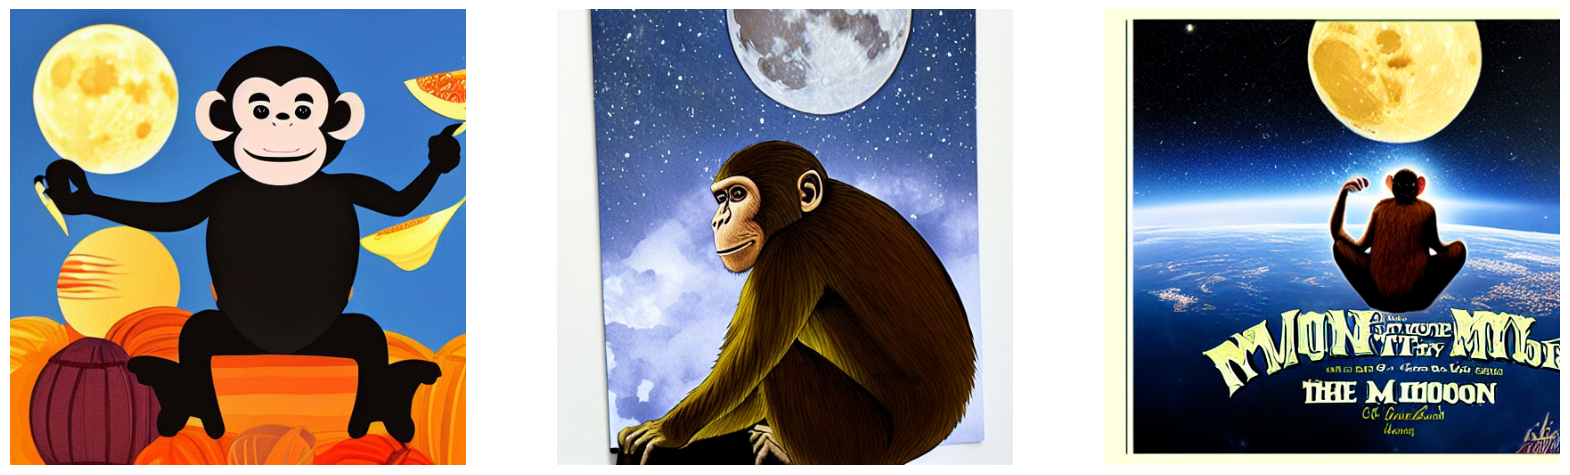

In [ ]:
images = model.text_to_image("monkey in the moon", batch_size=3)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)

50/50 [==============================] - 122s 2s/step


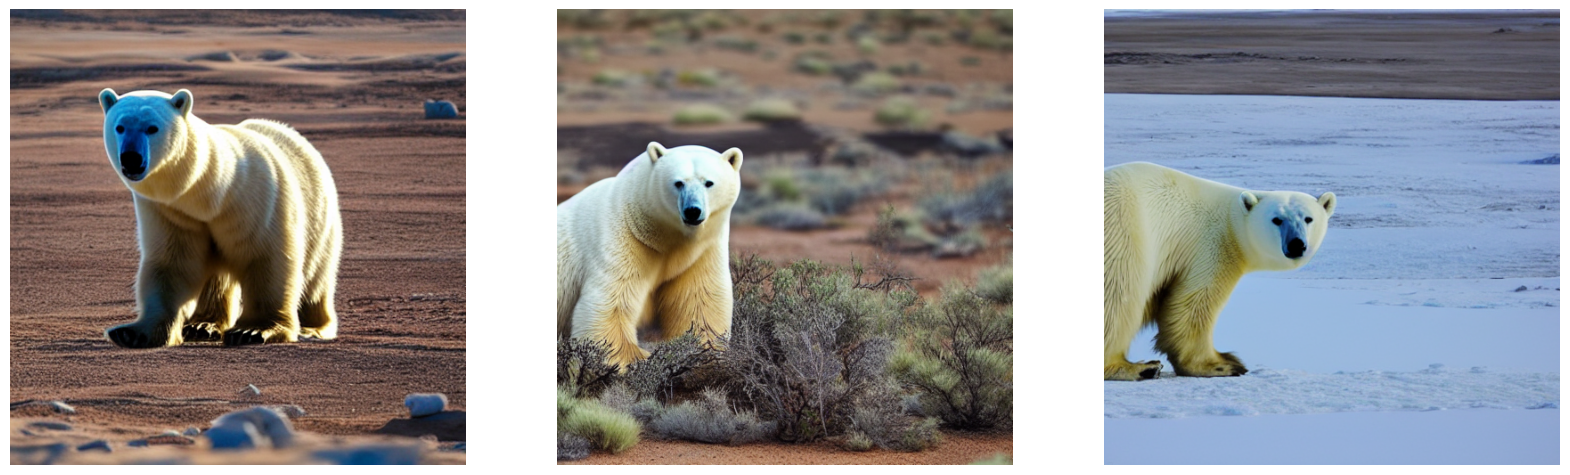

In [ ]:
images = model.text_to_image("polar bear in the desert", batch_size=3)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

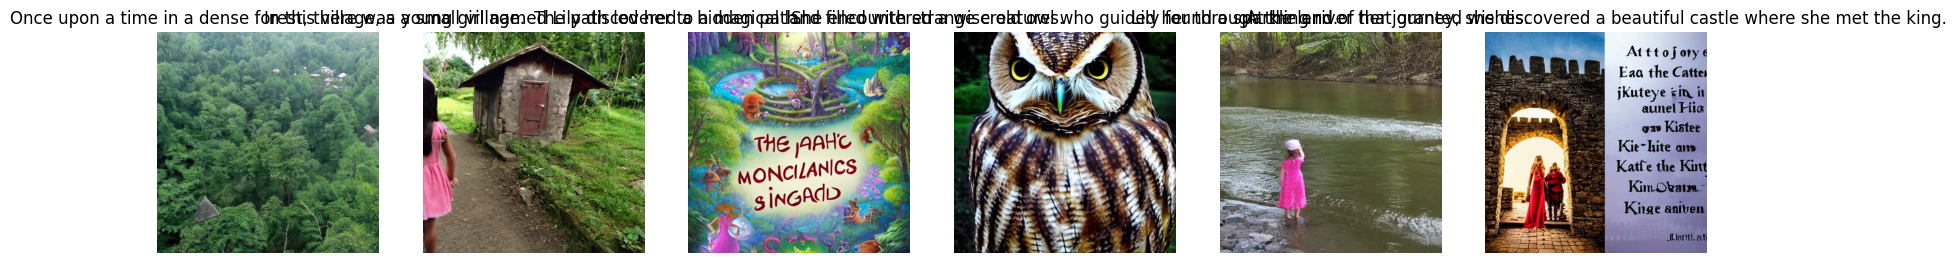

In [13]:
import torch
from diffusers import StableDiffusionPipeline

# Step 1: Load the pre-trained Stable Diffusion model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

# Step 2: Define the story prompts
story_prompts = [
    "Once upon a time in a dense forest, there was a small village.",
    "In this village, a young girl named Lily discovered a hidden path.",
    "The path led her to a magical land filled with strange creatures.",
    "She encountered a wise old owl who guided her through the land.",
    "Lily found a sparkling river that granted wishes.",
    "At the end of her journey, she discovered a beautiful castle where she met the king."
]

# Step 3: Generate images from the prompts
def generate_images(prompts, pipeline, device):
    images = []
    for prompt in prompts:
        with torch.no_grad():
            image = pipeline(prompt, num_inference_steps=50)["images"][0]
            images.append(image)
    return images

# Step 4: Generate images for the prompts
images = generate_images(story_prompts, pipeline, device)

# Step 5: Plot the generated images
import matplotlib.pyplot as plt

def plot_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

plot_images(images, story_prompts)


In [ ]:
!pip install diffusers